In [1]:
import numpy as np
from astropy import units
import pyccl as ccl
import sacc

import sys
sys.path.append('../../')

from matplotlib import pyplot as plt

# Set up cosmology

In [2]:
cosmo = ccl.Cosmology(Omega_c=0.25,
                      Omega_b=0.05,
                      h=0.7,
                      n_s=0.965,
                      A_s=2.11e-9,
                      Omega_k=0.0,
                      Neff=3.046,
                      matter_power_spectrum='linear')
b1_unwise = 1.0
s1_unwise = 0.4

In [20]:
cosmo

pyccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.7, n_s=0.965, sigma8=None, A_s=2.11e-09, Omega_k=0.0, Omega_g=None, Neff=3.046, w0=-1.0, wa=0.0, T_CMB=None, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, c1_mg=1.0, c2_mg=1.0, lambda_mg=0.0, m_nu=0.0, m_nu_type=None, z_mg=None, df_mg=None, transfer_function='boltzmann_camb', matter_power_spectrum='linear', baryons_power_spectrum='nobaryons', mass_function='tinker10', halo_concentration='duffy2008', emulator_neutrinos='strict')

# Set up binning

In [3]:
ell_max = 600
n_ell = 20
delta_ell = ell_max // n_ell

ells = (np.arange(n_ell) + 0.5) * delta_ell

ells_win = np.arange(ell_max + 1)
wins = np.zeros([n_ell, len(ells_win)])

for i in range(n_ell):
    wins[i, i * delta_ell : (i + 1) * delta_ell] = 1.0
    
Well = sacc.BandpowerWindow(ells_win, wins.T)

# Set up unWISE tracer

In [4]:
dndz_unwise = np.loadtxt('../../soliket/xcorr/data/dndz.txt')
ngal_unwise = 1.
fsky_unwise = 0.4

tracer_unwise_g = ccl.NumberCountsTracer(cosmo,
                                         has_rsd=False,
                                         dndz=dndz_unwise.T,
                                         bias=(dndz_unwise[:,0], b1_unwise * np.ones(len(dndz_unwise[:,0]))), 
                                         mag_bias=(dndz_unwise[:,0], s1_unwise * np.ones(len(dndz_unwise[:,0])))
                                         )

Nell_unwise_g = np.ones(n_ell) / (ngal_unwise * (60 * 180 / np.pi)**2)

# Set up SO CMB lensing tracer

In [5]:
zstar = 1086
fsky_solensing = 0.4

tracer_so_k = ccl.CMBLensingTracer(cosmo, z_source=zstar)

# Approximation to SO LAT beam
fwhm_so_k = 1. * units.arcmin
sigma_so_k = (fwhm_so_k.to(units.rad).value / 2.355)
ell_beam = np.arange(3000)
beam_so_k = np.exp(-ell_beam * (ell_beam + 1) * sigma_so_k**2)

# Calculate power spectra

In [6]:
n_maps = 2
cls = np.zeros([n_maps, n_maps, n_ell])

cls[0, 0, :] = ccl.angular_cl(cosmo, tracer_unwise_g, tracer_unwise_g, ells) + Nell_unwise_g

cls[0, 1, :] = ccl.angular_cl(cosmo, tracer_unwise_g, tracer_so_k, ells)
cls[1, 0, :] = cls[0, 1, :]

cls[1, 1, :] = ccl.angular_cl(cosmo, tracer_so_k, tracer_so_k, ells)

# Set up covariance

In [7]:
n_cross = (n_maps * (n_maps + 1)) // 2
covar = np.zeros([n_cross, n_ell, n_cross, n_ell])

id_i = 0
for i1 in range(n_maps):
    for i2 in range(i1, n_maps):
        id_j = 0
        for j1 in range(n_maps):
            for j2 in range(j1, n_maps):
                cl_i1j1 = cls[i1, j1, :]
                cl_i1j2 = cls[i1, j2, :]
                cl_i2j1 = cls[i2, j1, :]
                cl_i2j2 = cls[i2, j2, :]
                # Knox formula
                cov = (cl_i1j1 * cl_i2j2 + cl_i1j2 * cl_i2j1) / (delta_ell * fsky_solensing * (2 * ells + 1))
                covar[id_i, :, id_j, :] = np.diag(cov)
                id_j += 1
        id_i += 1
        
covar = covar.reshape([n_cross * n_ell, n_cross * n_ell])

# Construct sacc file

In [8]:
s = sacc.Sacc()

In [9]:
s.add_tracer('NZ', 'gc_unwise',
            quantity='galaxy_density',
            spin=0,
            z=dndz_unwise[:,0],
            nz=dndz_unwise[:,1],
            metadata={'ngal': ngal_unwise})

s.add_tracer('Map', 'ck_so',
            quantity='cmb_convergence',
            spin=0,
            ell=ell_beam,
            beam=beam_so_k)

In [10]:
s.add_ell_cl('cl_00',
             'gc_unwise',
             'gc_unwise',
             ells, cls[0, 0, :],
             window=Well)

s.add_ell_cl('cl_00',
             'gc_unwise',
             'ck_so',
             ells, cls[0, 1, :],
             window=Well)

s.add_ell_cl('cl_00',
             'ck_so',
             'ck_so',
             ells, cls[1, 1, :],
             window=Well)

In [11]:
s.add_covariance(covar)

In [12]:
s.save_fits('../../soliket/tests/data/unwise_g-so_kappa.sim.sacc.fits', overwrite=True)

# Read sacc file and compare to 'theory'

In [13]:
s_load = sacc.Sacc.load_fits('../../soliket/tests/data/unwise_g-so_kappa.sim.sacc.fits')

In [14]:
for n, t in s_load.tracers.items():
    print(t.name, t.quantity, type(t))

ck_so cmb_convergence <class 'sacc.tracers.MapTracer'>
gc_unwise galaxy_density <class 'sacc.tracers.NZTracer'>


In [15]:

# Type of power spectra
data_types = np.unique([d.data_type for d in s_load.data])
print("Data types: ", data_types)

# Tracer combinations
print("Tracer combinations: ", s_load.get_tracer_combinations())

# Data size
print("Nell: ", s_load.mean.size)

Data types:  ['cl_00']
Tracer combinations:  [('ck_so', 'ck_so'), ('gc_unwise', 'ck_so'), ('gc_unwise', 'gc_unwise')]
Nell:  60


In [16]:
ell_theory = np.linspace(1,ell_max,ell_max)

z_unwise = s_load.tracers['gc_unwise'].z
nz_unwise = s_load.tracers['gc_unwise'].nz

tracer_gc_unwise = ccl.NumberCountsTracer(cosmo, has_rsd=False,
                                          dndz=[z_unwise, nz_unwise],
                                          bias=(z_unwise, b1_unwise * np.ones(len(z_unwise))), 
                                          mag_bias=(z_unwise, s1_unwise * np.ones(len(z_unwise)))
                                         )

tracer_ck_so = ccl.CMBLensingTracer(cosmo, z_source=zstar)

cl_gg_theory = ccl.angular_cl(cosmo, tracer_gc_unwise, tracer_gc_unwise, ell_theory)
cl_gk_theory = ccl.angular_cl(cosmo, tracer_gc_unwise, tracer_ck_so, ell_theory)
cl_kk_theory = ccl.angular_cl(cosmo, tracer_ck_so, tracer_ck_so, ell_theory)

Nell_unwise_g = np.ones_like(ell_theory) / (s_load.tracers['gc_unwise'].metadata['ngal'] * (60 * 180 / np.pi)**2)

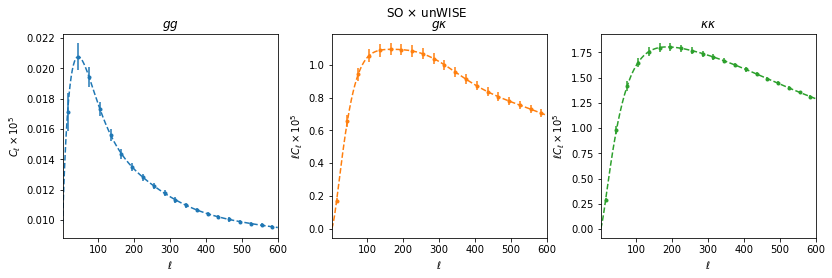

In [17]:
plt.figure(1, figsize=(3.*4.5, 3.75))

plt.suptitle(r'SO $\times$ unWISE')

plt.subplot(131)
plt.title(r'$gg$')
ell, cl, cov = s_load.get_ell_cl('cl_00', 'gc_unwise', 'gc_unwise', return_cov=True)
cl_err = np.sqrt(np.diag(cov))
plt.plot(ell_theory, 1.e5*(cl_gg_theory + Nell_unwise_g), '--', c='C0')
plt.plot(ell, 1.e5*cl, 'o', ms=3, c='C0')
plt.errorbar(ell, 1.e5*cl, yerr=1.e5*cl_err, fmt='none', c='C0')
plt.xlim([1,ell_max])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell \times 10^5$')

plt.subplot(132)
plt.title(r'$g\kappa$')
ell, cl, cov = s_load.get_ell_cl('cl_00', 'gc_unwise', 'ck_so', return_cov=True)
cl_err = np.sqrt(np.diag(cov))
plt.plot(ell_theory, 1.e5*ell_theory*cl_gk_theory , '--', c='C1')
plt.plot(ell, 1.e5*ell*cl, 'o', ms=3, c='C1')
plt.errorbar(ell, 1.e5*ell*cl, yerr=1.e5*ell*cl_err, fmt='none', c='C1')
plt.xlim([1,ell_max])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell C_\ell \times 10^5$')

plt.subplot(133)
plt.title(r'$\kappa\kappa$')
ell, cl, cov = s_load.get_ell_cl('cl_00', 'ck_so', 'ck_so', return_cov=True)
cl_err = np.sqrt(np.diag(cov))
plt.plot(ell_theory, 1.e5*ell_theory*cl_kk_theory , '--', c='C2')
plt.plot(ell, 1.e5*ell*cl, 'o', ms=3, c='C2')
plt.errorbar(ell, 1.e5*ell*cl, yerr=1.e5*ell*cl_err, fmt='none', c='C2')
plt.xlim([1,ell_max])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell C_\ell \times 10^5$')
plt.subplots_adjust(wspace=0.25);